In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from tqdm import tqdm
import os

In [ ]:
# Set CUDA_LAUNCH_BLOCKING environment variable
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
!pip install opendatasets --upgrade --quiet


In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/quadeer15sh/celeba-face-recognition-triplets'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mrunaldivekar2525
Your Kaggle Key: ··········


100%|██████████| 231M/231M [00:06<00:00, 36.7MB/s]


In [ ]:
# Define the image transformation pipeline
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to (256, 256) for consistency
    transforms.ToTensor(),
])

In [ ]:
# Download and load the human face dataset
data_dir = '/content/celeba-face-recognition-triplets'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [ ]:
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

In [ ]:
# Define the Variational Autoencoder (VAE) model
class VariationalAutoEncoder(nn.Module):
    def __init__(self, input_dim, z_dim, h_dim=200):
        super(VariationalAutoEncoder, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim),
            nn.ReLU()
        )
        self.mu = nn.Linear(h_dim, z_dim)
        self.log_var = nn.Linear(h_dim, z_dim)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, input_dim),
            nn.Sigmoid()  # Sigmoid activation for output images in [0, 1] range
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        log_var = self.log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x.view(x.size(0), -1))
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# Initialize VAE model
INPUT_DIM = 256 * 256 * 3  # Assuming RGB images
Z_DIM = 20
vae_model = VariationalAutoEncoder(input_dim=INPUT_DIM, z_dim=Z_DIM)


In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vae_model.to(device)

VariationalAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=196608, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
  )
  (mu): Linear(in_features=200, out_features=20, bias=True)
  (log_var): Linear(in_features=200, out_features=20, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=196608, bias=True)
    (3): Sigmoid()
  )
)

In [ ]:
# Define the training function
def train_vae(num_epochs, model, optimizer, loss_fn, train_loader):
    model.train()
    for epoch in range(num_epochs):
        loop = tqdm(train_loader, leave=True)
        for batch_idx, (x, _) in enumerate(loop):
            x = x.to(device)
            x_recon, mu, log_var = model(x)
            loss = loss_fn(x_recon, x, mu, log_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_description(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
# Define the loss function for VAE
def vae_loss(recon_x, x, mu, log_var):
    recon_loss = F.binary_cross_entropy(recon_x, x.view(-1, INPUT_DIM), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_div

In [ ]:
# Training parameters
NUM_EPOCHS = 5
BATCH_SIZE = 64
LR_RATE = 1e-3

In [ ]:
# DataLoader for training
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Initialize optimizer
optimizer = torch.optim.Adam(vae_model.parameters(), lr=LR_RATE)

In [ ]:
# Train the VAE
train_vae(NUM_EPOCHS, vae_model, optimizer, vae_loss, train_loader)

Epoch [4/5], Loss: 4240349.0000: 100%|██████████| 725/725 [02:38<00:00,  4.59it/s]


In [ ]:
# Function to generate images using trained VAE
def generate_images(model, num_images=10):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_images, Z_DIM).to(device)
        recon_images = model.decode(z).cpu()
        save_image(recon_images.view(-1, 3, 256, 256), 'generated_images.png', nrow=5)

# Generate images using trained VAE
generate_images(vae_model, num_images=10)

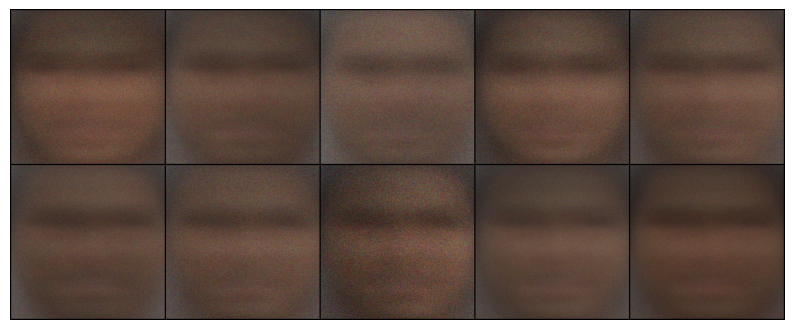

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Open the saved image file
image_path = 'generated_images.png'
image = Image.open(image_path)

# Display the image using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.axis('off')
plt.show()

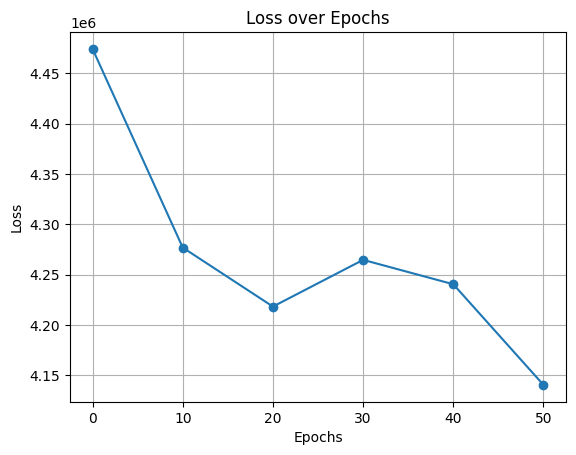

In [ ]:
import matplotlib.pyplot as plt

epochs = [0, 10, 20, 30, 40, 50]
losses = [4474115.0000, 4276766.5000, 4218166.0000, 4264574.5000, 4240349.0000, 4140349.0000]

plt.plot(epochs, losses, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.grid(True)
plt.show()


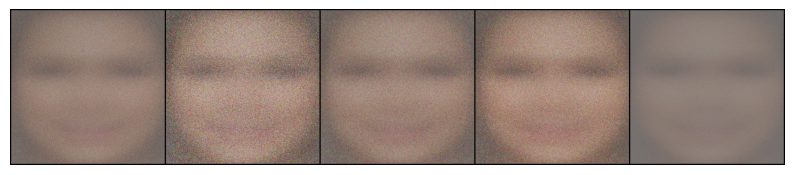

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

# Open the saved image file
image_path = 'generated_images.png'
image = Image.open(image_path)

# Display the image using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(image)
plt.axis('off')
plt.show()